In [1]:
import kagglehub
  # Kaggle'dan veri indirmek için gerekli kütüphaneyi içeri aktarıyoruz.
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")
  # "muratkokludataset/rice-image-dataset" adlı Kaggle veri setini indiriyoruz.
print("Path to dataset files:", path)
  # İndirilen veri kümesi dosyalarının nerede olduğunu ekrana yazdırıyoruz.

Path to dataset files: /kaggle/input/rice-image-dataset


In [2]:
from google.colab import files
files.upload()
  # Buradan indirdiğiniz kaggle.json dosyasını seçiyoruz

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salihcankeskin","key":"7c5de64950e14a37ea9041ef68bb63a6"}'}

In [3]:
!mkdir -p ~/.kaggle
  # Kullanıcının ana dizininde .kaggle adında bir dizin oluşturur
!mv kaggle.json ~/.kaggle/
  # Mevcut dizindeki kaggle.json dosyasını ~/.kaggle/ dizinine taşır.
!chmod 600 ~/.kaggle/kaggle.json
  #json dosyasının izinlerini yalnızca sahibi okuyup yazabilir hale getirir.

In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip -d rice_dataset
  # ZİP dosyasını açma

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: rice_dataset/Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: rice_da

In [6]:
import os

dataset_path = "/content/rice_dataset/Rice_Image_Dataset"

# Sadece alt dizinleri listeliyoruz yani pirinç türlerini.
pırınc_turleri = [d for d in os.listdir(dataset_path)
              if os.path.isdir(os.path.join(dataset_path, d))]

print("Pirinç Türleri:", pırınc_turleri)

# Örnek görüntü sayısını göster
for pırınc_tur in pırınc_turleri:
    images = os.listdir(f"{dataset_path}/{pırınc_tur}")
    print(f"{pırınc_tur}: {len(images)} görüntü")

Pirinç Türleri: ['Karacadag', 'Jasmine', 'Basmati', 'Ipsala', 'Arborio']
Karacadag: 15000 görüntü
Jasmine: 15000 görüntü
Basmati: 15000 görüntü
Ipsala: 15000 görüntü
Arborio: 15000 görüntü


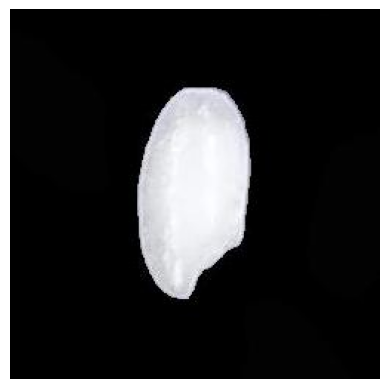

Pirinç türü: Arborio


In [40]:
import random
import matplotlib.pyplot as plt
import os

# Sadece alt klasörleri listele
pırınc_turleri = [d for d in os.listdir(dataset_path)
              if os.path.isdir(os.path.join(dataset_path, d))]

# Rastgele pirinç türü ve pirinç türünün resmini seçiyoruz.
random_class = random.choice(pırınc_turleri)
random_img = random.choice(os.listdir(f"{dataset_path}/{random_class}"))

# Görüntüyü gösteriyoruz
img = plt.imread(f"{dataset_path}/{random_class}/{random_img}")
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"Pirinç türü: {random_class}")

In [41]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Veri yolları ve parametreler
dataset_path = "/content/rice_dataset/Rice_Image_Dataset"
pırınc_turleri = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
label_dict = {label: idx for idx, label in enumerate(pırınc_turleri)}
size = 150  # Boyutu küçülttük (224'ten 150'ye)
batch_size = 32  # Daha küçük batch(küme) boyutu

# Veri çerçevesi oluşturma
img_paths = []
labels = []

for label in pırınc_turleri:
    label_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(label_path):
        img_paths.append(os.path.join(label_path, img_file))
        labels.append(label_dict[label])

# Veriyi karıştırma ve bölme
train_paths, test_paths, train_labels, test_labels = train_test_split(
    img_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# One-hot encoding
train_labels = to_categorical(train_labels, num_classes=len(pırınc_turleri))
test_labels = to_categorical(test_labels, num_classes=len(pırınc_turleri))

In [12]:
# Veri setinde yaklaşık 70.000 görsel var o nedenle hepsini belleğe yüklemeden verileri küçük gruplar
#halinde işlemek için RiceImageGenerator sınıfını kullanıyoruz.Veriyi batch lere ayırıyor(gruplara)
class RiceImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end() #veri karıştırma

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

        # resimlerin ön işlemesi (renkleri düzenleme,yeniden boyutlandırma,normalizasyon)
        batch_images = []
        for path in batch_paths:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0
            batch_images.append(img)

        return np.array(batch_images), np.array(batch_labels)

    # Her epoch işleminden sonra veriyi karıştırır fazla öğrenme olmasın diye.
    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)

In [13]:
train_generator = RiceImageGenerator(train_paths, train_labels, batch_size, size)
test_generator = RiceImageGenerator(test_paths, test_labels, batch_size, size)

In [42]:
def create_light_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        #İlk katman 16 filtre
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)), #Boyut küçültme

        #İkinxi katman 32 filtre
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #Üçüncü katman 64 filtre
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(), #resmi düzleştirme
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5), # aşırı öğrenmeyi engelleme
        tf.keras.layers.Dense(num_classes, activation='softmax') #Çıkış katmanı
    ])
      #Model derleme
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',  # çok sınıf
                 metrics=['accuracy'])

    return model

model = create_light_model((size, size, 3), len(pırınc_turleri))
model.summary() # modelin özetini yazdırma.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,717 (4.61 MB)

 Trainable params: 1,207,717 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Modelin eğitiminde aşırı öğrenme veya öğrenmeme olduğunda modeli durdurma.
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

# Model eğitimi
history = model.fit(train_generator,epochs=10,validation_data=test_generator,callbacks=callbacks,)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.8767 - loss: 0.3204 - val_accuracy: 0.9701 - val_loss: 0.0911 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9589 - loss: 0.1177 - val_accuracy: 0.9877 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.9820 - loss: 0.0571 - val_accuracy: 0.9926 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - accuracy: 0.9865 - loss: 0.0420 - val_accuracy: 0.9834 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.9889 - loss: 0.0365 - val_accuracy: 0.9953 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.9904 - loss: 0.0302 - val_accuracy: 0.9956 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accura

In [17]:
# Test verileri ile modelin başarı oranını ölçüyoruz.
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\nTest Doğruluğu: {test_acc*100:.2f}%")
print(f"Test Kaybı: {test_loss:.4f}")

469/469 - 14s - 30ms/step - accuracy: 0.9963 - loss: 0.0141

Test Doğruluğu: 99.63%
Test Kaybı: 0.0141


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


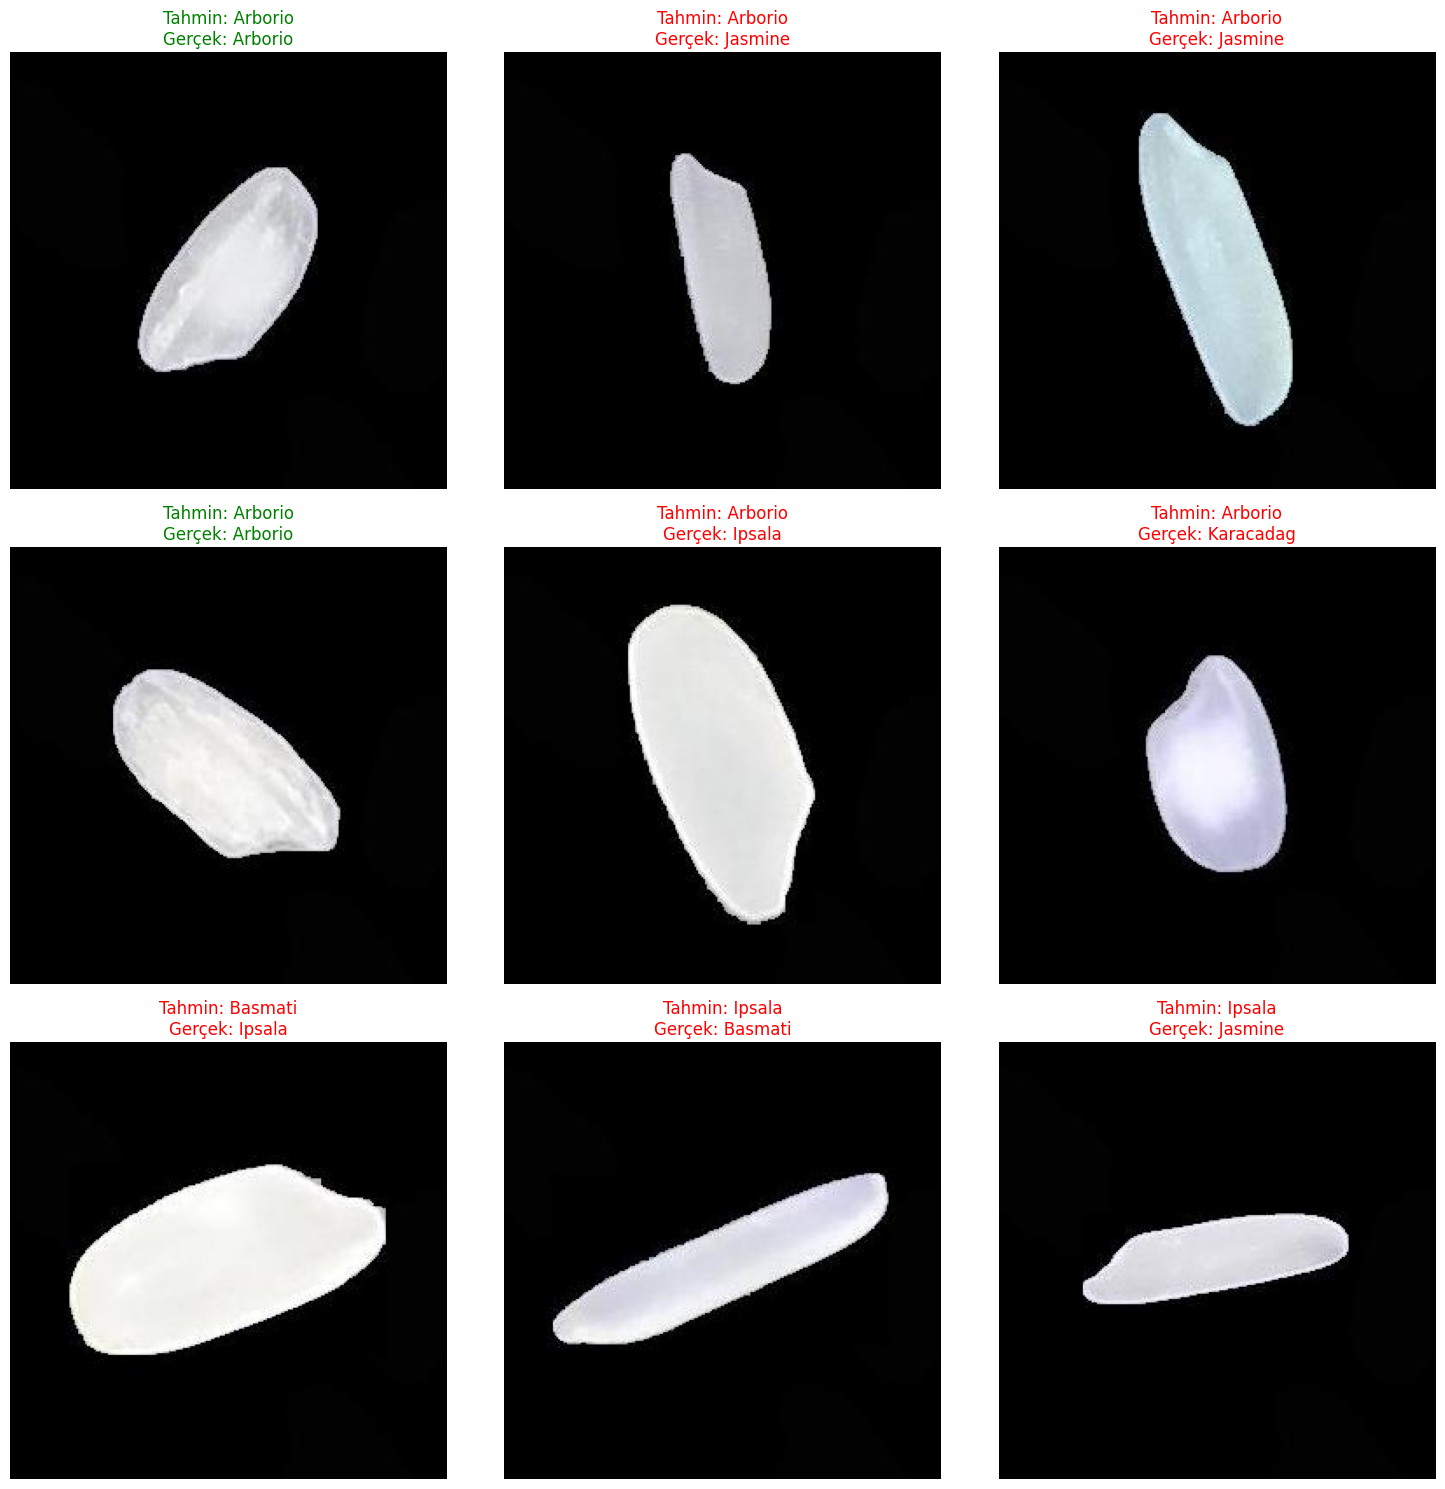

In [43]:
import matplotlib.pyplot as plt
import random

# Rastgele 9 örnek seçme
sample_indices = random.sample(range(len(test_paths)), 9)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(sample_indices):
    # Resmi yükleme
    img = cv2.imread(test_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (size, size)) / 255.0

    # Tahmin yapma
    prediction = model.predict(np.expand_dims(img_resized, axis=0))
    predicted_label = pırınc_turleri[np.argmax(prediction)]
    true_label = pırınc_turleri[np.argmax(test_labels[idx])]

    # Görselleştirme
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"Tahmin: {predicted_label}\nGerçek: {true_label}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

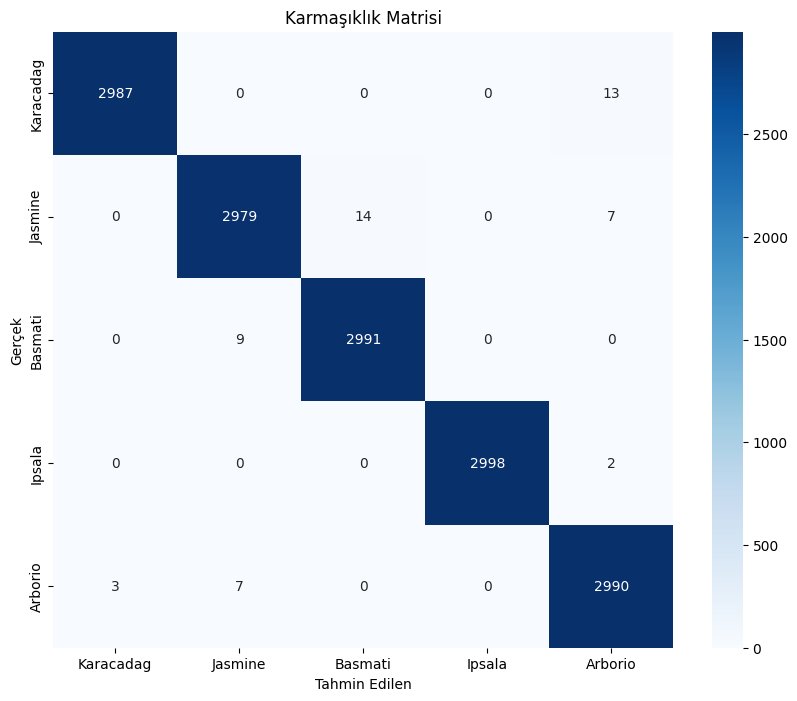

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Tüm test verisi için tahmin yapma
y_pred = []
y_true = []

for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]
    preds = model.predict(batch_x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_y, axis=1))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pırınc_turleri, yticklabels=pırınc_turleri)
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

In [45]:
# Modelin raporu
from sklearn.metrics import classification_report

print("Sınıf Bazında Performanslar:")
print(classification_report(y_true, y_pred, target_names=pırınc_turleri))

Sınıf Bazında Performanslar:
              precision    recall  f1-score   support

   Karacadag       1.00      1.00      1.00      3000
     Jasmine       0.99      0.99      0.99      3000
     Basmati       1.00      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Arborio       0.99      1.00      0.99      3000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [21]:
# Modeli kaydetme
model.save('rice_classification_model.h5')

import pickle
with open('label_dict.pkl', 'wb') as f:
    pickle.dump(label_dict, f)

Model başarıyla kaydedildi.
Etiket sözlüğü kaydedildi.


 Model ve etiketler başarıyla yüklendi

 Rastgele Pirinç Tahmini
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


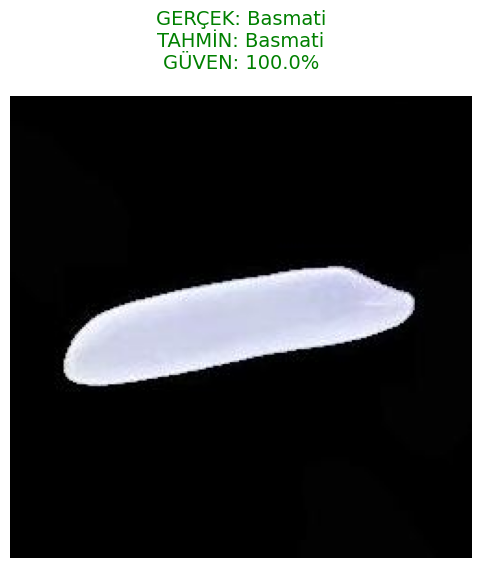


 Gerçek Tür: Basmati
Tahmin: Basmati (%100.0 güven)
Doğru


('Basmati', np.float32(100.0))

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.models import load_model
import pickle

# Modeli Yükleme
try:
    model = load_model('rice_classification_model.h5')
    with open('label_dict.pkl', 'rb') as f:
        pırınc_turleri = list(pickle.load(f).keys())
    print(" Model ve etiketler başarıyla yüklendi")
except:
    print(" Model bulunamadı")
    print("Lütfen önce modeli eğitin ve kaydedin")
    exit()

# Veri seti içerisinden rastgele resim seçme
def get_random_rice_image(dataset_path="/content/rice_dataset/Rice_Image_Dataset"):
    try:
        # Pirinç türlerini listeleme
        rice_types = [d for d in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, d))]

        if not rice_types:
            raise ValueError("Pirinç türü klasörleri bulunamadı")

        # Rastgele bir tür seç
        random_class = random.choice(rice_types)
        class_path = os.path.join(dataset_path, random_class)

        # Rastgele bir resim seç
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not images:
            raise ValueError(f"{random_class} klasöründe uygun resim bulunamadı")

        random_image = random.choice(images)
        return os.path.join(class_path, random_image)

    except Exception as e:
        print(f"Hata: {str(e)}")
        return None

# Tahmin
def predict_random_rice():
    try:
        # Rastgele resim seç
        image_path = get_random_rice_image()
        if image_path is None:
            return

        # Resmi yükleme ve tahmin
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Dosya okunamadı")

        # Ön işleme
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display_img = img.copy()
        img = cv2.resize(img, (150, 150)) / 255.0

        # Tahmin
        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_class = pırınc_turleri[np.argmax(prediction)]
        confidence = round(np.max(prediction)*100, 2)
        true_class = os.path.basename(os.path.dirname(image_path))

        # Sonucu göster
        plt.figure(figsize=(10,6))
        plt.imshow(display_img)
        plt.title(f"GERÇEK: {true_class}\nTAHMİN: {predicted_class}\nGÜVEN: {confidence}%",
                 fontsize=14, pad=20, color='green' if true_class==predicted_class else 'red')
        plt.axis('off')
        plt.show()

        print(f"\n Gerçek Tür: {true_class}")
        print(f"Tahmin: {predicted_class} (%{confidence} güven)")
        print(f"Doğru" if true_class==predicted_class else "Yanlış")

        return predicted_class, confidence

    except Exception as e:
        print(f"\n Hata: {str(e)}")
        return None, None

# Kullanım
print("\n Rastgele Pirinç Tahmini")
predict_random_rice()

Model ve etiketler başarıyla yüklendi

 Pirinç Türü Tahmin Uygulaması
Lütfen bir pirinç görseli yükle...


Saving basmati_uzak.jpg to basmati_uzak (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


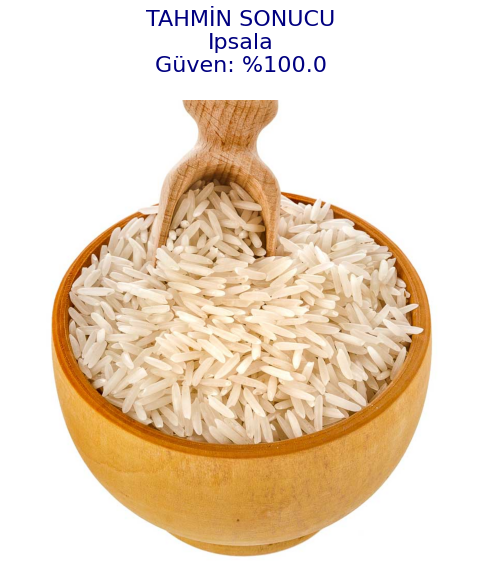


Yüklenen dosya: basmati_uzak (3).jpg
Tahmin edilen tür: Ipsala
Güven: %100.0


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle
from google.colab import files

# Model Yükleme
try:
    model = load_model('rice_classification_model.h5')
    with open('label_dict.pkl', 'rb') as f:
        pırınc_turleri = list(pickle.load(f).keys())
    print("Model ve etiketler başarıyla yüklendi")
except:
    print("Model bulunamadı")
    exit()

# Dosya yükleme resim
def upload_and_predict():
    # Kullanıcıdan dosya yüklemesini isteme
    uploaded = files.upload()

    if not uploaded:
        print("Hiç dosya yüklenmedi. Lütfen bir dosya yükleyin.")
        return

    # Yüklenen dosyayı al
    file_name = next(iter(uploaded))
    file_path = f"/content/{file_name}"

    try:
        # Resmi yükle
        img = cv2.imread(file_path)
        if img is None:
            raise ValueError("Dosya okunamadı format yanlış")

        # Ön işleme
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display_img = img.copy()
        img = cv2.resize(img, (150, 150)) / 255.0  # Modelin eğitildiği boyuta indirgeme

        # Tahmin yap
        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_class = pırınc_turleri[np.argmax(prediction)]
        confidence = round(np.max(prediction)*100, 2)

        # Sonucu göster
        plt.figure(figsize=(10, 6))
        plt.imshow(display_img)
        plt.title(f"TAHMİN SONUCU\n{predicted_class}\nGüven: %{confidence}",
                 fontsize=16, pad=20, color='navy')
        plt.axis('off')
        plt.show()

        print(f"\nYüklenen dosya: {file_name}")
        print(f"Tahmin edilen tür: {predicted_class}")
        print(f"Güven: %{confidence}")

        return predicted_class, confidence

    except Exception as e:
        print(f"\n Hata oluştu: {str(e)}")
        return None, None

# Kullanım
print("\n Pirinç Türü Tahmin Uygulaması")
print("Lütfen bir pirinç görseli yükle...")
predicted_class, confidence = upload_and_predict()

Model ve etiketler başarıyla yüklendi

 Pirinç Türü Tahmin Uygulaması
Lütfen bir pirinç görseli yükle...


Saving basmati.jpg to basmati (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


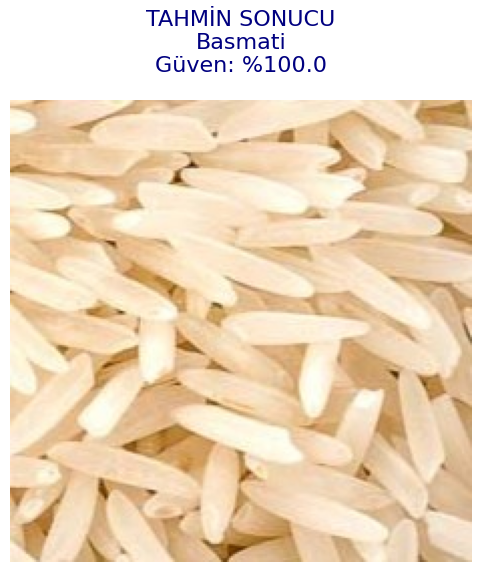


Yüklenen dosya: basmati (2).jpg
Tahmin edilen tür: Basmati
Güven: %100.0


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle
from google.colab import files

# Model Yükleme
try:
    model = load_model('rice_classification_model.h5')
    with open('label_dict.pkl', 'rb') as f:
        pırınc_turleri = list(pickle.load(f).keys())
    print("Model ve etiketler başarıyla yüklendi")
except:
    print("Model bulunamadı")
    exit()

# Dosya yükleme resim
def upload_and_predict():
    # Kullanıcıdan dosya yüklemesini isteme
    uploaded = files.upload()

    if not uploaded:
        print("Hiç dosya yüklenmedi. Lütfen bir dosya yükleyin.")
        return

    # Yüklenen ilk dosyayı al
    file_name = next(iter(uploaded))
    file_path = f"/content/{file_name}"

    try:
        # Resmi yükle
        img = cv2.imread(file_path)
        if img is None:
            raise ValueError("Dosya okunamadı format yanlış")

        # Ön işleme
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display_img = img.copy()
        img = cv2.resize(img, (150, 150)) / 255.0  # Modelin eğitildiği boyuta indirgeme

        # Tahmin yap
        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_class = pırınc_turleri[np.argmax(prediction)]
        confidence = round(np.max(prediction)*100, 2)

        # Sonucu göster
        plt.figure(figsize=(10, 6))
        plt.imshow(display_img)
        plt.title(f"TAHMİN SONUCU\n{predicted_class}\nGüven: %{confidence}",
                 fontsize=16, pad=20, color='navy')
        plt.axis('off')
        plt.show()

        print(f"\nYüklenen dosya: {file_name}")
        print(f"Tahmin edilen tür: {predicted_class}")
        print(f"Güven: %{confidence}")

        return predicted_class, confidence

    except Exception as e:
        print(f"\n Hata oluştu: {str(e)}")
        return None, None

# Kullanım
print("\n Pirinç Türü Tahmin Uygulaması")
print("Lütfen bir pirinç görseli yükle...")
predicted_class, confidence = upload_and_predict()